<h1 align="center">Diffusion Maps</h1>
<h5 align="center">construction 1</h5>

## Framework

Given 
- $X=\{x_1,...,x_n\}\in\mathbb{R}^p$, the data set,
- $\sigma$, the scaling parameter, 
- $s$, the number of the eigenvalues we computed, 
- $clusters$, the number of groups of data,
- $t$, the time parameter in the diffusion process,

I constructed the diffusion map refer to [Ann Lee's Matlab code](https://reurl.cc/E3Ykv):

1. ***Construct the affinity matrix $K$***  
Define $K$ with entries
$$K_{ij}=\exp(-\frac{d(x_i,x_j)^2}{\sigma}).$$


2. ***Construct the normalize affinity matrix $Q$***  
Define $Q$ with entries 
$$Q_{ij}=\frac{K_{ij}}{\sqrt{\sum_{j=1}^nK_{ij}\sum_{i=1}^nK_{ij}}}.$$


3. ***Calculate the first $c$ largest eigenvalues and eigenvectors of the diffusion matrix P***  
The eigenvalues of $P$ is equal to the eigenvalues of Q.  
The right and left eigenvectors of P are 
$$\psi_j=e_je_1,\quad \phi_j=e_j/e_1$$
respectively, where $e_j$ is the eigenvector of the corresponding $j$'th eigenvalue of $Q$.  
Note that the multiplication and division are elementwise.


4. ***Define a diffusion map $Y$***  
Note that Ann Lee's code allows one to set the time parameter $t$ in the diffusion process.  
Define $Y$ with columns
$$Y_j =
    \begin{cases}
      \left[ \frac{\lambda_j}{1-\lambda_j}\psi_j \right] & \text{if $t$=0,}\\
      \left[ \lambda_j^t \psi_j \right] & \text{otherwise.}
    \end{cases}       
$$

5. ***Cluster via k-means***  
Using k-means to cluster data into $clusters$ groups in the diffusion space.

## Implementation

### 1. Import libraries

In [1]:
%pylab inline
from scipy.io import loadmat
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


### 2. Load data

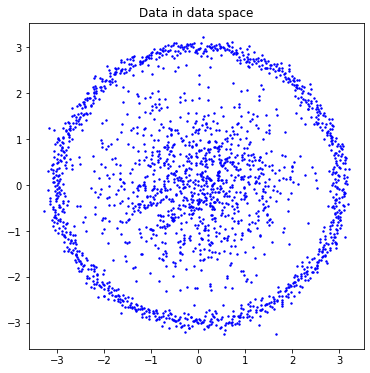

number of data:  2000


In [2]:
ori=loadmat('Data/Data.mat')

n,p=ori['Data'].shape

plt.scatter(ori['Data'][:,0],ori['Data'][:,1], s=2, c="blue")
plt.title("Data in data space")
plt.gcf().set_size_inches(6,6)
#plt.savefig('1.png')
plt.show()

print('number of data: ',n)

### 3. Define functions

In [3]:
def diffuse(data):
    
    K = get_K(data)              #the affinity matrix 
    Q = get_Q(K)                 #the normalize affinity matrix
    psi, eigenvals = get_eig(Q)  #the eigenvectors and eigenvalues of diffusion matrix
    Y = get_Y(psi, eigenvals)    #the diffusion map
    labels = get_labels(Y)
    
    return Y, labels, eigenvals

***3.1. Construct the affinity matrix $K$***  

In [4]:
def get_K(data):
    Dis=squareform(pdist(data))
    K=exp(-Dis*Dis/sigma)

    return K

***3.2. Construct the normalize affinity matrix $Q$***  

In [5]:
def get_Q(K):
    D=diag(1/sqrt(sum(K, axis=1)))
    Q=D.dot(K).dot(D)
    
    #turn Q into a sparse matrix to speed up calculation
    threshold = 5e-6
    
    Q[Q<threshold]=0
    Q=csr_matrix(Q, dtype=float)
    
    return Q

***3.3. Calculate the first $c$ largest eigenvalues and the corresponding eigenvectors of the diffusion matrix $P$***  

Note that the function `scds` is called to compute the largest c singular values and corresponding singular vectors. Since $Q$ is a real symmetric matrix, singular values and non-negative eigenvalues coincide.

In [6]:
def get_eig(Q):
    U,S,V = svds(Q, c+1)
    
    eigenvals=S[::-1]
    
    U=U[:,::-1]
    
    temp=U[:,0].reshape(n,1)
    e1=U[:,0].reshape(n,1)
    for i in range(c): e1=hstack((e1,temp))
    
    psi=(1/e1)*U
    phi=e1*U
        
    return psi, eigenvals

***3.4. Define the diffusion map $Y$*** 

In [7]:
def get_Y(psi, eigenvals):
    if t!=0: Y=psi.dot(diag(eigenvals**t))
    else: Y=psi.dot(diag(eigenvals/(1-eigenvals)))
        
    return Y    #Y is the diffusion map

***3.5. Cluster via k-means***  

In [8]:
def get_labels(Y):

    kmeans = KMeans(clusters)
    kmeans = kmeans.fit(Y)
    labels = array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

### 4. Set parameters

Ann Lee guessed sigma by considering the distance between one point to its k-nearest neighbor point.

In [9]:
s=2
Dis=squareform(pdist(ori['Data']))
D_sort=sort(Dis,1)
print("suggest sigma = ", 2*percentile(D_sort[:,s+1],50)**2)

suggest sigma =  0.01551198623232377


In [10]:
data=ori['Data'] #data set
sigma=0.015      #scaling parameter
c=7              #the number of the eigenvalues we computed
clusters=2       #the number of groups of data
t=0              #time parameter in the diffusion process

### 5. Calculate the diffusion map and labeling

In [11]:
Y, labels, eigenvals = diffuse(data)

### 6. Display results

***6.1. Fall-off of eigenvalues of diffusion matrix***

This indicated why Ann Lee used $\frac{\lambda}{1-\lambda}$ instead of $\lambda$ to construct the diffusion map. (The fall-off of $\frac{\lambda_j}{1-\lambda_j}$ is faster, making the dimensional reduction more effective.)

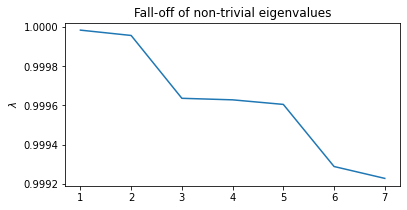

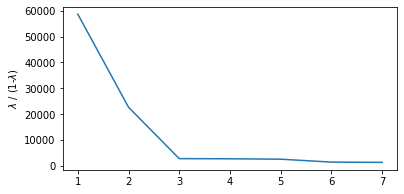

In [12]:
plt.plot(range(1,c+1),eigenvals[1:c+1])
plt.title('Fall-off of non-trivial eigenvalues')
plt.ylabel('$\lambda$')
plt.gcf().set_size_inches(6,3)
plt.show()

if t!=0:
    plt.plot(range(1,c+1), pow(eigenvals[1:c+1], t))
    plt.ylabel('$\lambda$^t')
else:
    plt.plot(range(1,c+1), eigenvals[1:c+1]/(1-eigenvals[1:c+1]) )
    ylabel('$\lambda$ / (1-$\lambda$)')

plt.gcf().set_size_inches(6,3)
plt.show()

***6.2. Data in diffusion space***

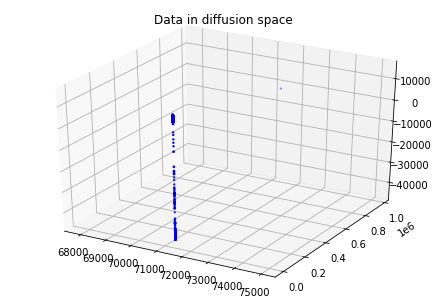

In [13]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Y[:,0],Y[:,1],Y[:,2],s=2, c='b')
plt.title('Data in diffusion space') 
#plt.savefig('2.png')
plt.show()

***6.3. data after labeling***

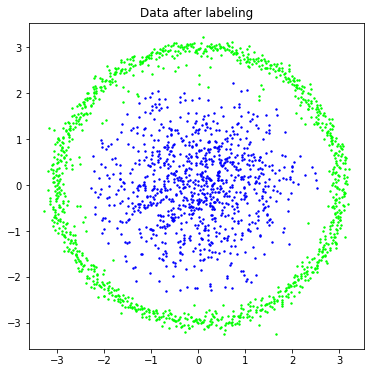

In [14]:
cmap=cm.brg
norm=Normalize(1, clusters)

for i in range(n): plt.scatter(data[i][0], data[i][1], s=2, c=cmap(norm(labels[i]+1)) )
plt.title('Data after labeling')
plt.gcf().set_size_inches(6,6)
#plt.savefig('3.png')
plt.show()